In [ ]:
# TODO: remove libraries that we don't use

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from transformers import BertTokenizer, BertModel
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from scipy.stats import f_oneway
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from utilities import *
import pandas as pd
import numpy as np 
import torch
import json
import os

In [2]:
# pick full or smaller version of dataset
df = pd.read_csv('data/modelready_220423.csv')

## Cleaning and baseline models

In [3]:
# print non-numerical columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
print(f'tot columns = {len(df.columns)}, numeric type columns = {len(df.select_dtypes(include=numerics).columns)}' ) # not too many non-numeric columns
df.select_dtypes(include = ['object']).head(1)  

tot columns = 772, numeric type columns = 765


,publication_number,company_name,countries_in_family,publn_nr,primary_cpc,abstract,description_text
0,US-8623043-B1,"Entellus Medical, Inc.",['AU' 'EP' 'CA' 'US'],8623043,A61M29/02,A method of treating a constricted sinus passa...,RELATED APPLICATIONS \n This Application i...


In [4]:
# extract unique countries in the df
unique_values = set()
df['countries_in_family'].apply(lambda x: unique_values.update(x.strip("[]").replace("'", "").split())) 

# Create new columns for each unique value
for value in unique_values:
    # each country has a column (1 if the patent belong to the country 0 otherwise)
    df[value] = df['countries_in_family'].apply(lambda x: 1 if value in x else 0)


In [5]:
df = df[df.abstract.notna()].copy() # drop all samples without abstract
print('missing value in description text' , df.description_text.isna().sum()) # description_text doesn't have mssing vales

missing value in description text 0


In [6]:
# encode company names
df['company_name_encoded'] = df.company_name.astype('category').cat.codes  # encode companies

# remove non-numeric columns
df_columns_dropped = df.drop(['publication_number', 'company_name', 'countries_in_family', 'publn_nr','primary_cpc'], axis = 1)

# f0_ has the same value as commercialization, the other two shouldn't be used
df_columns_dropped = df_columns_dropped.drop(['f0_', 'centrality', 'similarity'], axis = 1)

In [7]:
# remove text as I can't compute min and max on it
text = df_columns_dropped[['abstract', 'description_text']] # putting them aside for later
df_columns_dropped.drop(['abstract', 'description_text'], axis=1, inplace=True)

In [8]:
# extracting what we'll try to predict
y = df_columns_dropped['commercialized']
df_columns_dropped.drop('commercialized', axis= 1, inplace=True)

In [9]:
# dropping columns where all the value are the same (only one unique value) they would be zero if I apply min max rescaling
nunique = df_columns_dropped.nunique()
cols_to_drop = nunique[nunique == 1].index
df_clean = df_columns_dropped.drop(cols_to_drop, axis=1)

In [10]:
# splitting train and test and trying best preprocessing on training set
X_train, X_test, y_train, y_test = train_test_split(df_clean, y, test_size=0.20)

### Select best way to fill missin values

In [69]:
# TODO: rerun
# find best method for filling missing values

accuracies = []

#rescale 
scaler = StandardScaler()
filling_methods = ['mean', 'median', 'most_frequent', 'zero']

for method in filling_methods:
    # Make a copy of the original data to avoid modifying it
    data_filled = X_train.copy()

    # Fill NaN values based on the selected method
    if method == 'zero':
        data_filled = data_filled.fillna(0)  # You can choose any constant value
    else:
        imputer = SimpleImputer(strategy=method)
        data_filled = imputer.fit_transform(data_filled)


    # default max_iter was reached, so increased it
    model = LogisticRegression(max_iter=1000)

    #rescale 
    scaler.fit(data_filled)
    data_filled = scaler.transform(data_filled)

    # Perform cross-validation and print the mean score
    scores_dict = cross_validate(estimator=model, X=data_filled, y=y_train, n_jobs=5, cv=5,scoring=['f1', 'accuracy', 'precision', 'recall'])

    accuracies.append(scores_dict["test_accuracy"])

    # Print the results
    print(f'method:{method}')
    print(f'Average F1 Score: {np.mean(scores_dict["test_f1"])}')
    print(f'Average Accuracy: {np.mean(scores_dict["test_accuracy"])}')
    print(f'Average Precision: {np.mean(scores_dict["test_precision"])}')
    print(f'Average Recall: {np.mean(scores_dict["test_recall"])}')
    print() 

method:mean
Average F1 Score: 0.8762373397343263
Average Accuracy: 0.8925440214140211
Average Precision: 0.888147051573761
Average Recall: 0.8646528881823

method:median
Average F1 Score: 0.8760319845737824
Average Accuracy: 0.8924507813233152
Average Precision: 0.8886779403557968
Average Recall: 0.8637519872813991

method:most_frequent
Average F1 Score: 0.8757006021574447
Average Accuracy: 0.8921943275900956
Average Precision: 0.8886171941764587
Average Recall: 0.8631690514043455

method:zero
Average F1 Score: 0.8759290773874614
Average Accuracy: 0.8923808458198135
Average Precision: 0.8887496528779693
Average Recall: 0.8634870164281929



In [96]:
# perform ANOVA test to see if there is significant difference between the accuracies

f_statistic, p_value = f_oneway(*accuracies)

# Print the results
print(f'F-statistic: {f_statistic}')
print(f'P-value: {p_value}')

# Check if the p-value is below the significance level (e.g., 0.05)
if p_value < 0.05:
    print('The means of the accuracy vectors are significantly different.')
else:
    print('There is no significant difference in means between the accuracy vectors.')

F-statistic: 0.1862935451418707
P-value: 0.9041639871526389
There is no significant difference in means between the accuracy vectors.


So, it doesn't matter which filling method we will use

### Model selection

In [14]:
# model selection

accuracies = []

pipe_step = [('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Fill missing values with zero
    ('scaler', StandardScaler())]

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Neural Network': MLPClassifier(random_state=42),
    'Gradient Boosted Trees': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

# Perform model selection using cross-validation
for model_name, model in models.items():
    

    pipeline = Pipeline(pipe_step + [(model_name, model)])
    # Print the cross-validation scores
    scores_dict = cross_validate(estimator=pipeline, X=X_train, y=y_train, cv=5, n_jobs=5, scoring=['f1', 'accuracy', 'precision', 'recall'])

    accuracies.append(scores_dict["test_accuracy"])

    # Print the results
    print(f'model:{model_name}')
    print(f'Average F1 Score: {np.mean(scores_dict["test_f1"])}')
    print(f'Average Accuracy: {np.mean(scores_dict["test_accuracy"])}')
    print(f'Average Precision: {np.mean(scores_dict["test_precision"])}')
    print(f'Average Recall: {np.mean(scores_dict["test_recall"])}')
    print() 


model:Random Forest
Average F1 Score: 0.9101360594178912
Average Accuracy: 0.9212440975187857
Average Precision: 0.9164947072291995
Average Recall: 0.9038837516512549

model:Logistic Regression
Average F1 Score: 0.8763326865082062
Average Accuracy: 0.8925440975106325
Average Precision: 0.890181888645414
Average Recall: 0.8629326287978865

model:Neural Network
Average F1 Score: 0.898466699502195
Average Accuracy: 0.9108225932252111
Average Precision: 0.9026228535826984
Average Recall: 0.8943725231175694

model:Gradient Boosted Trees
Average F1 Score: 0.8851684647269235
Average Accuracy: 0.9009138876886309
Average Precision: 0.9056931119791016
Average Recall: 0.8655746367239102

model:SVM
Average F1 Score: 0.8770946778012678
Average Accuracy: 0.8941061380858348
Average Precision: 0.8988565835677578
Average Recall: 0.8563804491413475



In [15]:
# perform ANOVA test to see if there is significant difference between the accuracies
f_statistic, p_value = f_oneway(*accuracies)

# Print the results
print(f'F-statistic: {f_statistic}')
print(f'P-value: {p_value}')

# Check if the p-value is below the significance level (e.g., 0.05)
if p_value < 0.05:
    print('The means of the accuracy vectors are significantly different.')
else:
    print('There is no significant difference in means between the accuracy vectors.')

F-statistic: 209.0706359263085
P-value: 5.202365520366976e-16
The means of the accuracy vectors are significantly different.


Text(0.5, 1.0, 'Log Mean Accuracy of Different Models')

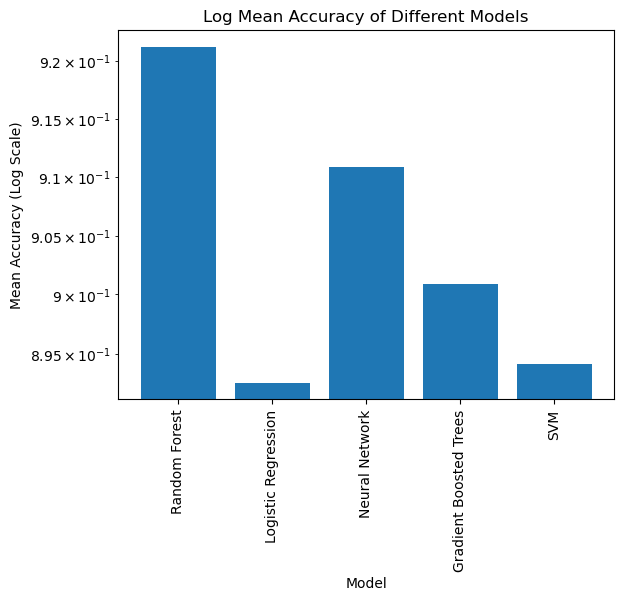

In [23]:
# log is used to make differences easier to see
plt.bar(models.keys(), np.mean(accuracies, axis = 1))

plt.yscale('log')

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Mean Accuracy (Log Scale)')
plt.xticks(rotation=90)
plt.title('Log Mean Accuracy of Different Models')

### Vectorization of text (bag of words)

In [11]:
# putting text back in
df_clean[['abstract', 'description_text']] = text  

# split again
X_train, X_test, y_train, y_test = train_test_split(df_clean, y, test_size=0.20, random_state=42)

In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize  # You may need to install nltk and download punkt

# Example: Assuming 'X_train' contains your abstracts
# Tokenize the text
tokenized_text = [word_tokenize(text) for text in X_train['abstract']]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=8)

# Encode abstracts using the trained Word2Vec model
encoded_abstracts = []
for words in tokenized_text:
    # Take the mean of word vectors for each abstract
    encoded_abstract = np.mean([word2vec_model.wv[word] for word in words if word in word2vec_model.wv] or [np.zeros(100)], axis=0)
    encoded_abstracts.append(encoded_abstract)

# 'encoded_abstracts' now contains the encoded versions of your abstracts
encoded_abstracts

In [56]:
np.array(encoded_abstracts).shape

(42892, 100)

In [59]:
# Create pipeline, will use teh best model found before
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Fill missing values with zero
    ('scaler', StandardScaler(with_mean=False)), 
    ('random_forest', RandomForestClassifier(random_state=42))
    ])

# Define vectorizers
vectorizers = {
    'Word2Vec' : None,
    'Count Vectorizer': CountVectorizer(max_features = 100),
    'TF-IDF Vectorizer': TfidfVectorizer(max_features = 100),
}

X_train_only_text = X_train[['abstract']]
# Tokenize text for Word2Vec
tokenized_text = [word_tokenize(text) for text in X_train['abstract']]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)
accuracies = []
# Transform text data using different vectorization methods and evaluate models

for vectorizer_name, vectorizer in vectorizers.items():
    if 'Word Embeddings' in vectorizer_name:
        # Use Word Embeddings (Word2Vec) for Word Embeddings model
        X_train_transformed = np.array([np.mean([word2vec_model.wv[word] for word in words if word in word2vec_model.wv] or [np.zeros(100)], axis=0) for words in tokenized_text])
    else:
        # Use Count Vectorization or TF-IDF Vectorization for other models
        X_train_transformed = vectorizer.fit_transform(X_train_only_text['abstract'].values)

    # Evaluate the model using cross-validation
    scores_dict = cross_validate(pipeline, X_train_transformed, y_train, cv=5, n_jobs=5, scoring=['f1', 'accuracy', 'precision', 'recall'])

    # Print the mean accuracy for each combination
    accuracies.append(scores_dict["test_accuracy"])

    # Print the results
    print(f'model:{vectorizer_name}')
    print(f'Average F1 Score: {np.mean(scores_dict["test_f1"])}')
    print(f'Average Accuracy: {np.mean(scores_dict["test_accuracy"])}')
    print(f'Average Precision: {np.mean(scores_dict["test_precision"])}')
    print(f'Average Recall: {np.mean(scores_dict["test_recall"])}')
    print() 


model:Word Embeddings
Average F1 Score: 0.7418224287863632
Average Accuracy: 0.7866270234122911
Average Precision: 0.7933449457174385
Average Recall: 0.6966407030326003

model:Count Vectorizer
Average F1 Score: 0.7002568860936353
Average Accuracy: 0.7605614853688911
Average Precision: 0.7794670706396095
Average Recall: 0.635810414231918

model:TF-IDF Vectorizer
Average F1 Score: 0.6922232835707994
Average Accuracy: 0.7548727581768458
Average Precision: 0.7733293088034816
Average Recall: 0.6265904392900886



Word2Vec has the highest accuracy among the different vectorizers, but in any case the performances have dropped compared to when we didn't use the abstract. This can be explained by the increased number of features which cause overfitting on thetraining set. 

## Searching for most relevant features

In [ ]:
# baseline case
train_RF(df_clean, y)

In [ ]:
# case 1 - no google embeddings
google_embeddings = ['v1_0', 'v1_1', 'v1_2', 'v1_3', 'v1_4', 'v1_5', 'v1_6', 'v1_7', 'v1_8', 'v1_9', 'v1_10', 'v1_11', 'v1_12', 'v1_13', 'v1_14', 'v1_15', 'v1_16', 'v1_17', 'v1_18', 'v1_19', 'v1_20', 'v1_21', 'v1_22', 'v1_23', 'v1_24', 'v1_25', 'v1_26', 'v1_27', 'v1_28', 'v1_29', 'v1_30', 'v1_31', 'v1_32', 'v1_33', 'v1_34', 'v1_35', 'v1_36', 'v1_37', 'v1_38', 'v1_39', 'v1_40', 'v1_41', 'v1_42', 'v1_43', 'v1_44', 'v1_45', 'v1_46', 'v1_47', 'v1_48', 'v1_49', 'v1_50', 'v1_51', 'v1_52', 'v1_53', 'v1_54', 'v1_55', 'v1_56', 'v1_57', 'v1_58', 'v1_59', 'v1_60', 'v1_61', 'v1_62', 'v1_63']
df_no_google = modify_df(df_clean, google_embeddings)
print("Case 1: No google embeddings")
train_RF(df_no_google, y)

# case 2 - no future info
future_info = ['forward_citations','litigated', 'renewed_after_first_term', 'renewed_after_second_term', 'renewed_after_third_term', 'opposed', 'fwd_cites_same_company']
df_no_future = modify_df(df_clean, future_info)
print("Case 2: No future information")
train_RF(df_no_future, y)

# case 3 - no vpm_patent_score
vpm_patent_score = ['vpm_patent_score']
df_no_vpm = modify_df(df_clean, vpm_patent_score)
print("Case 3: No vpm_patent_score")
train_RF(df_no_vpm, y)

# case 4 - no primary cpc as we are not supposed to normalized ------ ALREADY NOT THERE, MAYBE ENCODED IN DUMMY? CHECK
# primary_cpc = ['primary_cpc']
# df_no_cpc = modify_df(df_clean, primary_cpc)
# print("Case 4: No primary_cpc")
# train_RF(df_no_cpc, y)

In [ ]:
# CASE 5 - CPA, taking no future info as baseline as it achieved max accuracy

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

data = df_no_future.copy()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

pca = PCA()
pca.fit(scaled_data)

In [ ]:
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [ ]:
desired_variance = 0.95
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= desired_variance) + 1
print("Number of components selected:", n_components)

In [ ]:
pca = PCA(n_components=627)
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame with the principal components
pc_df = pd.DataFrame(data=principal_components)

train_RF(pc_df,y)

In [ ]:
# CASE 5 - CPA, taking no future info as baseline as it achieved max accuracy

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

data = df_no_future.copy()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Display the explained variance ratio
print("Explained Variance Ratio:")
print(pca.explained_variance_ratio_)

# Plot the results
plt.scatter(pc_df['PC1'], pc_df['PC2'])
plt.title('PCA Result')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.show()

In [ ]:
# CASE 6 - using chi-square for feature selection


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

data = df_no_future.copy()
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

x_train, x_test, y_train, y_test = train_test_split(scaled_data, y, test_size=0.20)

k_best = SelectKBest(score_func=chi2, k='all')
k_best.fit(x_train, y_train)

selected_features_indices = k_best.get_support(indices=True)
selected_features_names = [f"feature_{i}" for i in selected_features_indices]

x_train_selected = k_best.transform(x_train)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(x_train_selected, y_train)
y_pred = rf_classifier.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'F1_score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')



In [ ]:
# CASE 7 - f regression for feature selection

from sklearn.feature_selection import f_classif

data = df_no_future.copy()
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

x_train, x_test, y_train, y_test = train_test_split(scaled_data, y, test_size=0.20)

k_best = SelectKBest(score_func=f_classif, k='all')
k_best.fit(x_train, y_train)

selected_features_indices = k_best.get_support(indices=True)
selected_features_names = [f"feature_{i}" for i in selected_features_indices]

x_train_selected = k_best.transform(x_train)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(x_train_selected, y_train)
y_pred = rf_classifier.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'F1_score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

## Trying Bert to make prediction on the abstract and text description

In [11]:

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

# Define your dataset class
class CustomDataset(Dataset):
    def __init__(self, features, texts, labels, tokenizer, max_length):
        self.features = features
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        text = list(self.texts.iloc[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        return {
            'features': torch.tensor(self.features.iloc[idx]),
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


from transformers import BertModel

class CustomBERTClassifier(torch.nn.Module):
    def __init__(self, num_classes, feature_dim):
        super(CustomBERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased', num_labels=num_classes)
        
        # Freeze all BERT layers except the last three
        for param in self.bert.parameters():
            param.requires_grad = False
        for param in self.bert.encoder.layer[-3:].parameters():
            param.requires_grad = True

        self.fc = torch.nn.Linear(feature_dim + self.bert.config.hidden_size, 128)  # Adjust as needed
        self.final_layer = torch.nn.Linear(128, num_classes)

    def forward(self, input_ids, attention_mask, features):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output

        # Concatenate BERT output with additional features
        combined_features = torch.cat([pooled_output, features], dim=1)

        # Fully connected layer
        combined_features = torch.relu(self.fc(combined_features))

        # Final classification layer
        logits = self.final_layer(combined_features)

        return logits

In [12]:
df_clean[['abstract', 'description_text']] = text  # incorporate text
X_train, X_test, y_train, y_test = train_test_split(df_clean, y, test_size=0.20, random_state=42)

In [14]:
# load model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device  = 'cpu'

# Set up your data and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 128  # Adjust as needed
num_classes = 2  # Binary classification

# reset indexes, otherwise it doesn't work
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

features = X_train.drop(['abstract', 'description_text'], axis = 1)
texts = X_train[['abstract', 'description_text']]

dataset = CustomDataset(features, texts, y_train, tokenizer, max_length)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = CustomBERTClassifier(num_classes, len(features.columns))
model.to(device)  # Move the model to GPU if available

print('loaded')

loaded


In [15]:

# Set up your optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
num_epochs = 4  # Adjust as needed

for epoch in range(num_epochs):
    print('epoch:', epoch)
    model.train()
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        features = batch['features'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        features = features.to(torch.float32)       
        outputs = model(input_ids, attention_mask=attention_mask, features=features)
        loss = torch.nn.functional.cross_entropy(outputs, labels)

        loss.backward()
        optimizer.step()    

        # explicity memory release otherwise fills all RAM
        del input_ids, attention_mask, features, labels, outputs, loss

/home/stefano/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
3

In [16]:
# prediction
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

features = X_test.drop(['abstract', 'description_text'], axis = 1)
texts = X_test[['abstract', 'description_text']]

dataset = CustomDataset(features, texts, y_test, tokenizer, max_length)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Make predictions for all elements in the dataset
all_predictions = []

with torch.no_grad():
    for batch in dataloader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']

        logits = model(input_ids, attention_mask=attention_mask)
        predicted_classes = torch.argmax(logits, dim=1).tolist()

        all_predictions.extend(predicted_classes)

In [17]:
(all_predictions == y_test).sum() / len(y_test)

0.5040096978739277

### conclusion

It takes very long to train (20 hours) and the result on the text are close to random. 